<a href="https://colab.research.google.com/github/rajalingam24/Emotion-Detection/blob/main/Approach_Transfer_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Xception **Model** **bold text**

In [ ]:
# Importing necessary libraries

import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/fer2013.csv'

df = pd.read_csv(dataset_path)

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


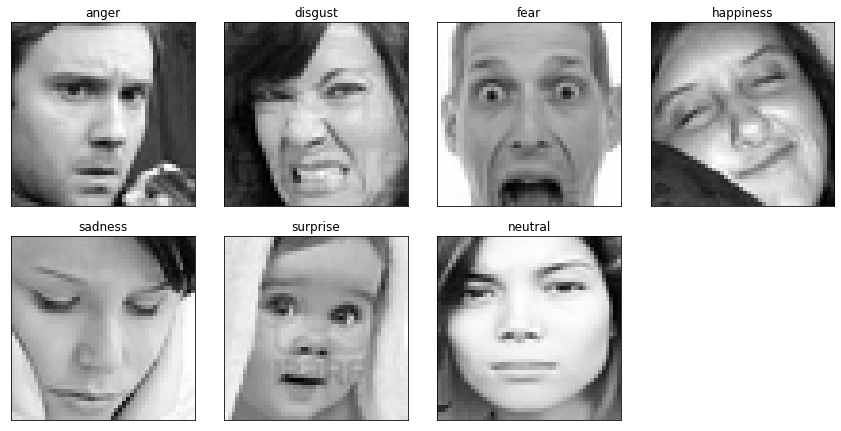

In [ ]:
emotions_dummy = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (12, 12))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(1):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(4, 4, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions_dummy[label])
        plt.tight_layout()

In [ ]:
image_size=(48,48)

# Data Loading and Pre-Processing Functionalities

def load_dataset(data):
    data = (data[data['pixels'].notnull()])
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        face = cv2.cvtColor(face, cv2.COLOR_GRAY2BGR)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_data(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [ ]:
train_data = df.loc[df['Usage']=='Training']      # Training Data
valid_data = df.loc[df['Usage']=='PublicTest']    # Validation Data
test_data  = df.loc[df['Usage']=='PrivateTest']   # Test Data

print (len(train_data), len (valid_data), len(test_data))  # Printing the len of all the data

28709 3589 3589


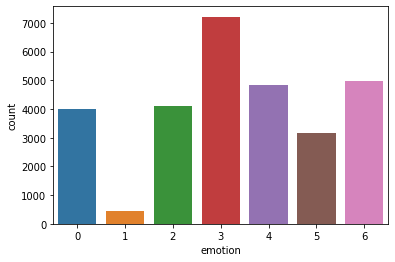

In [ ]:
import seaborn as sns
sns.countplot(data=train_data, x = 'emotion')
plt.show()

In [ ]:
X_train, Y_train = load_dataset(train_data)
#X_train = preprocess_data(X_train)
Y_train = to_categorical(Y_train)
    
print("Shape of X_Train = {}".format(X_train.shape))
print("Shape of Y_Train = {}".format(Y_train.shape))

Shape of X_Train = (28709, 48, 48, 3)
Shape of Y_Train = (28709, 7)


In [ ]:
# PublicTest / Validation Data - Extraction & Pre-Processing

X_val, Y_val = load_dataset(valid_data)
#X_val = preprocess_data(X_val)
Y_val = to_categorical(Y_val)

print("Shape of X_Val = {}".format(X_val.shape))
print("Shape of Y_Val = {}".format(Y_val.shape))

Shape of X_Val = (3589, 48, 48, 3)
Shape of Y_Val = (3589, 7)


In [ ]:
# PrivateTest / Evaluation Data - Extraction & Pre-Processing

X_eval, Y_eval = load_dataset(test_data)
#X_eval = preprocess_data(X_eval)
Y_eval = to_categorical(Y_eval)

print("Shape of X_Eval = {}".format(X_eval.shape))
print("Shape of Y_Eval = {}".format(Y_eval.shape))

Shape of X_Eval = (3589, 48, 48, 3)
Shape of Y_Eval = (3589, 7)


In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

In [ ]:
#parameters 

batch_size = 32
epochs = 50
image_shape = (48, 48, 3)
verbose = True 
num_class = 7
patience = 50  # number of epochs with no improvement after which training will be stopped
base_path = './'
l2_regularization = 0.01

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255,featurewise_center=False, featurewise_std_normalization=False, rotation_range=10, 
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=.1, horizontal_flip=True)

In [ ]:
regularization = l2(l2_regularization)

In [ ]:
# model
from keras.layers import Input,SeparableConv2D,GlobalAveragePooling2D
from keras import layers
image_input = Input(image_shape)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(image_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# module 1
# residual module 
residual = Conv2D(filters=16, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 2
# residual module 
residual = Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 3
# residual module 
residual = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 4
# residual module 
residual = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

x = Conv2D(filters=num_class, kernel_size=(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)

output = Activation('softmax', name='predictions')(x)

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 8) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/gamma:0' shape=(8,) dtype=float32>
  <tf.Variable 'batch_normalization/beta:0' shape=(8,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'co

In [ ]:
model = Model(image_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 35,880
Trainable params: 35,880
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
history=model.fit_generator(data_generator.flow(X_train, Y_train, batch_size), 
                  steps_per_epoch=len(X_train)/batch_size, epochs=epochs, verbose=verbose, 
                   validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
897/897 [==============================] - 59s 30ms/step - loss: 1.8272 - accuracy: 0.2493 - val_loss: 89.6085 - val_accuracy: 0.2497
Epoch 2/50
897/897 [==============================] - 27s 30ms/step - loss: 1.7799 - accuracy: 0.2692 - val_loss: 99.8983 - val_accuracy: 0.3266
Epoch 3/50
897/897 [==============================] - 27s 30ms/step - loss: 1.6994 - accuracy: 0.3256 - val_loss: 110.6119 - val_accuracy: 0.3566
Epoch 4/50
897/897 [==============================] - 27s 31ms/step - loss: 1.6470 - accuracy: 0.3523 - val_loss: 119.9860 - val_accuracy: 0.3837
Epoch 5/50
897/897 [==============================] - 27s 30ms/step - loss: 1.6008 - accuracy: 0.3753 - val_loss: 150.0013 - val_accuracy: 0.4082
Epoch 6/50
897/897 [==============================] - 27s 30ms/step - loss: 1.5543 - accuracy: 0.3969 - val_loss: 134.0137 - val_accuracy: 0.4344
Epoch 7/50
897/897 [==============================] - 27s 30ms/step - loss: 1.5180 - accuracy: 0.4130 - val_loss: 133.2437 - v

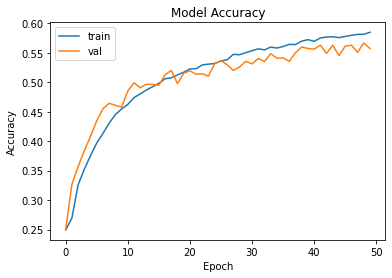

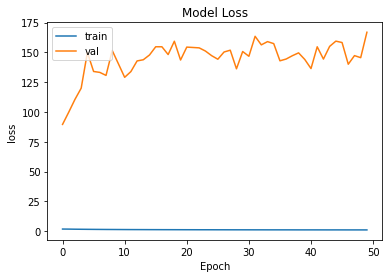

In [ ]:
# Plotting Performance Metrics


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_val)
y_true = Y_val

In [ ]:
y_true = np.argmax(y_true,axis=1)
y_pred = np.argmax(y_pred>0.5,axis=1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Angry','disgust', 'fear', 'happy','sad','surprise', 'neutral']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Angry       0.42      0.55      0.48       467
     disgust       0.41      0.23      0.30        56
        fear       0.40      0.28      0.33       496
       happy       0.84      0.73      0.78       895
         sad       0.47      0.45      0.46       653
    surprise       0.61      0.74      0.67       415
     neutral       0.49      0.54      0.52       607

    accuracy                           0.56      3589
   macro avg       0.52      0.50      0.50      3589
weighted avg       0.56      0.56      0.56      3589



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

In [ ]:
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

In [ ]:
confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = target_names, 
                                columns = target_names)

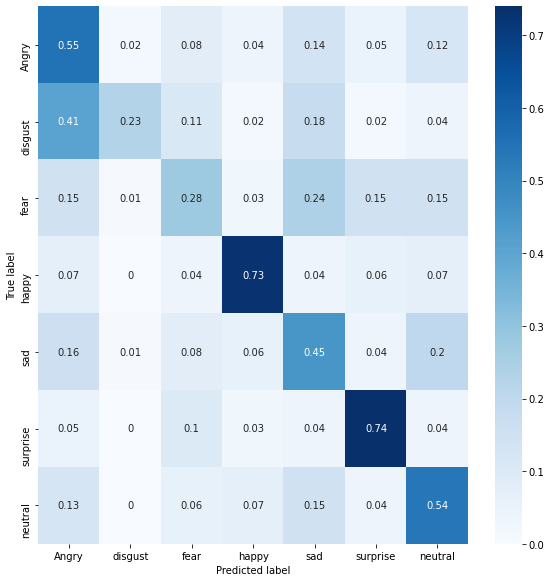

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
Evaluate the value

In [ ]:
y_predev = model.predict(X_eval)
y_true1 = Y_eval

In [ ]:
y_true1 = np.argmax(y_true1,axis=1)
y_predev = np.argmax(y_predev>0.5,axis=1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
print(classification_report(y_true1, y_predev, target_names=target_names))

              precision    recall  f1-score   support

    surprise       0.52      0.55      0.53       491
        fear       0.47      0.49      0.48        55
       angry       0.45      0.44      0.44       528
     neutral       0.80      0.86      0.83       879
         sad       0.48      0.43      0.46       594
     disgust       0.79      0.61      0.69       416
       happy       0.57      0.64      0.60       626

    accuracy                           0.61      3589
   macro avg       0.58      0.57      0.58      3589
weighted avg       0.61      0.61      0.61      3589



In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_true1, Y_predev, output_dict=True)
report = pd.DataFrame(report_dict)

report

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true1, y_predev)
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

In [ ]:
confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = target_names, 
                                columns = target_names)

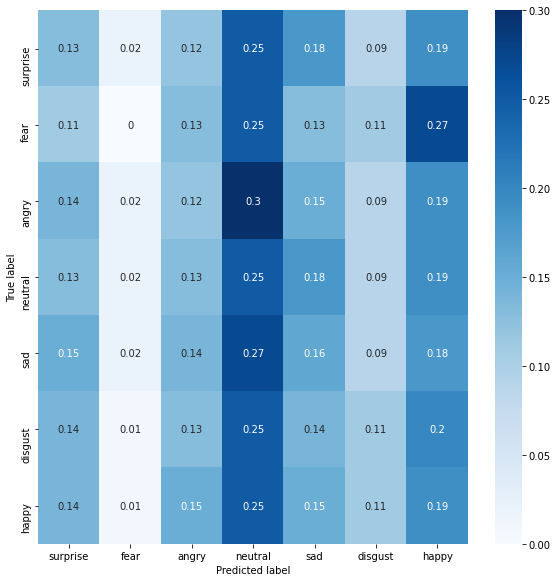

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

VGG model design

In [ ]:
num_classes = len (train_data['emotion'].unique())

# Defining VGG16 Custom Layers for Transfer Learning
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (48,48, 3)) # Defining the base model

# Freezing the layers
for layer in base_model.layers:
    layer.trainable=False

# Building Model
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
historyvgg=model.fit_generator(data_generator.flow(X_train, Y_train, batch_size), 
                  steps_per_epoch=len(X_train)/batch_size, epochs=25, verbose=verbose, 
                   validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
897/897 [==============================] - 58s 31ms/step - loss: 1.7819 - acc: 0.2793 - val_loss: 24.2800 - val_acc: 0.2327
Epoch 2/25
897/897 [==============================] - 27s 30ms/step - loss: 1.7378 - acc: 0.2999 - val_loss: 23.9974 - val_acc: 0.2488
Epoch 3/25
897/897 [==============================] - 27s 30ms/step - loss: 1.7279 - acc: 0.3057 - val_loss: 27.9128 - val_acc: 0.2463
Epoch 4/25
897/897 [==============================] - 27s 30ms/step - loss: 1.7235 - acc: 0.3083 - val_loss: 23.2986 - val_acc: 0.2254
Epoch 5/25
897/897 [==============================] - 27s 30ms/step - loss: 1.7210 - acc: 0.3104 - val_loss: 32.1091 - val_acc: 0.2446
Epoch 6/25
897/897 [==============================] - 27s 30ms/step - loss: 1.7209 - acc: 0.3070 - val_loss: 30.4242 - val_acc: 0.2396
Epoch 7/25
897/897 [==============================] - 27s 30ms/step - loss: 1.7182 - acc: 0.3139 - val_loss: 25.6722 - val_acc: 0.2421
Epoch 8/25
897/897 [==============================] - 2

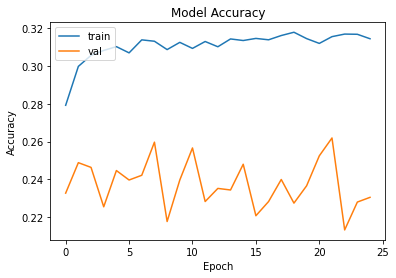

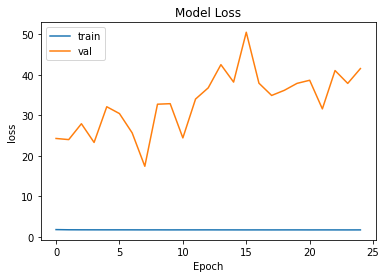

In [ ]:
# Plotting Performance Metrics


plt.plot(historyvgg.history['acc'])
plt.plot(historyvgg.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyvgg.history['loss'])
plt.plot(historyvgg.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predvgg = model.predict(X_val)
y_truevgg = Y_val

In [ ]:
y_truevgg = np.argmax(y_truevgg,axis=1)
y_predvgg = np.argmax(y_predvgg>0.5,axis=1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
print(classification_report(y_truevgg, y_predvgg, target_names=target_names))

              precision    recall  f1-score   support

    surprise       0.15      0.23      0.18       467
        fear       0.00      0.00      0.00        56
       angry       0.26      0.03      0.06       496
     neutral       0.40      0.17      0.24       895
         sad       0.38      0.06      0.10       653
     disgust       0.40      0.24      0.30       415
       happy       0.20      0.67      0.31       607

    accuracy                           0.23      3589
   macro avg       0.26      0.20      0.17      3589
weighted avg       0.30      0.23      0.20      3589



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_truevgg, y_predvgg)
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(labels=y_truevgg, predictions=y_predvgg).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

In [ ]:
confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = target_names, 
                                columns = target_names)

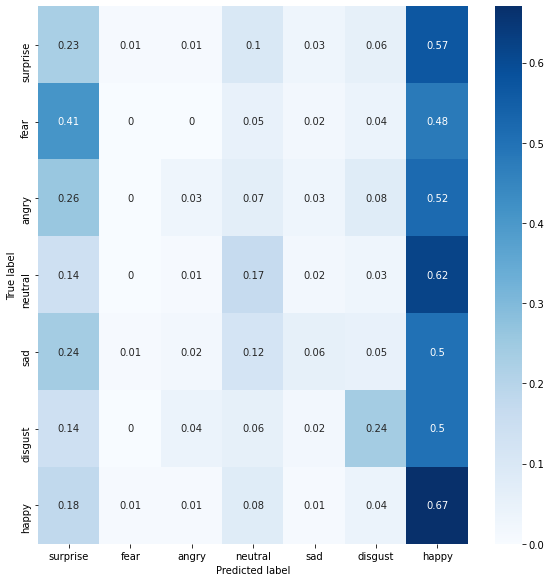

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Evaluation Using VGG

In [ ]:
y_predvggeval = model.predict(X_eval)
y_truevggeval = Y_eval

In [ ]:
y_truevggeval = np.argmax(y_truevggeval,axis=1)
y_predvggeval = np.argmax(y_predvggeval>0.5,axis=1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
print(classification_report(y_truevggeval, y_predvggeval, target_names=target_names))

              precision    recall  f1-score   support

    surprise       0.20      0.31      0.24       491
        fear       0.14      0.04      0.06        55
       angry       0.36      0.04      0.07       528
     neutral       0.40      0.18      0.25       879
         sad       0.30      0.06      0.11       594
     disgust       0.40      0.25      0.30       416
       happy       0.22      0.69      0.33       626

    accuracy                           0.25      3589
   macro avg       0.29      0.22      0.19      3589
weighted avg       0.32      0.25      0.22      3589



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_truevgg, y_predvgg)
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(labels=y_truevggeval, predictions=y_predvggeval).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

In [ ]:
confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = target_names, 
                                columns = target_names)

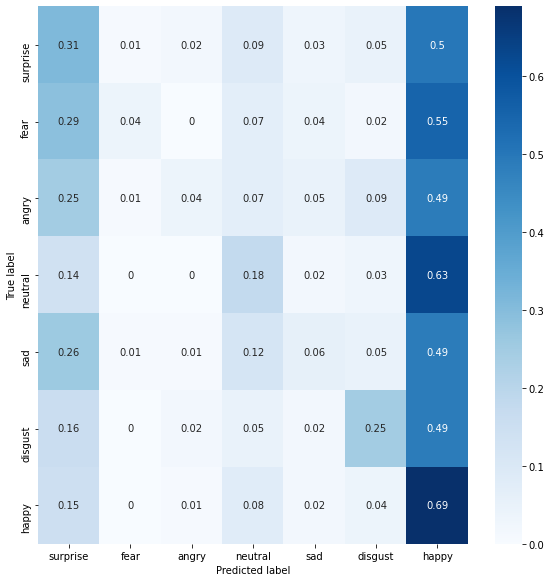

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Resnet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from keras.applications.nasnet import NASNetLarge
num_classes = len (train_data['emotion'].unique())
base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Build model on the top of base model
model = Sequential()

model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())

# fully connected layer-1
model.add(Dense(128, kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# fully connected layer-2
model.add(Dense(64, kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# fully connected layer-3
model.add(Dense(32, kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# output layer
model.add(Dense(7, activation = 'softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
historyres50=model.fit_generator(data_generator.flow(X_train, Y_train, batch_size), 
                  steps_per_epoch=len(X_train)/batch_size, epochs=25, verbose=verbose, 
                   validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
897/897 [==============================] - 65s 34ms/step - loss: 1.8585 - acc: 0.2318 - val_loss: 7.6987 - val_acc: 0.2034
Epoch 2/25
897/897 [==============================] - 31s 34ms/step - loss: 1.8013 - acc: 0.2493 - val_loss: 8.6112 - val_acc: 0.1594
Epoch 3/25
897/897 [==============================] - 31s 34ms/step - loss: 1.7809 - acc: 0.2632 - val_loss: 9.6885 - val_acc: 0.1374
Epoch 4/25
897/897 [==============================] - 30s 34ms/step - loss: 1.7712 - acc: 0.2666 - val_loss: 10.0499 - val_acc: 0.2382
Epoch 5/25
897/897 [==============================] - 29s 33ms/step - loss: 1.7585 - acc: 0.2750 - val_loss: 10.3391 - val_acc: 0.2184
Epoch 6/25
897/897 [==============================] - 29s 33ms/step - loss: 1.7579 - acc: 0.2720 - val_loss: 14.3909 - val_acc: 0.2321
Epoch 7/25
897/897 [==============================] - 29s 33ms/step - loss: 1.7505 - acc: 0.2815 - val_loss: 18.6198 - val_acc: 0.1964
Epoch 8/25
897/897 [==============================] - 29s 

In [ ]:
y_predres = model.predict(X_val)
y_trueres = Y_val

y_trueres = np.argmax(y_trueres,axis=1)
y_predres = np.argmax(y_predres>0.5,axis=1)

from sklearn.metrics import classification_report
target_names = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
print(classification_report(y_trueres, y_predres, target_names=target_names))

              precision    recall  f1-score   support

    surprise       0.20      0.03      0.06       467
        fear       0.00      0.00      0.00        56
       angry       0.00      0.00      0.00       496
     neutral       0.25      0.95      0.39       895
         sad       0.00      0.00      0.00       653
     disgust       0.10      0.01      0.02       415
       happy       0.00      0.00      0.00       607

    accuracy                           0.24      3589
   macro avg       0.08      0.14      0.07      3589
weighted avg       0.10      0.24      0.11      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


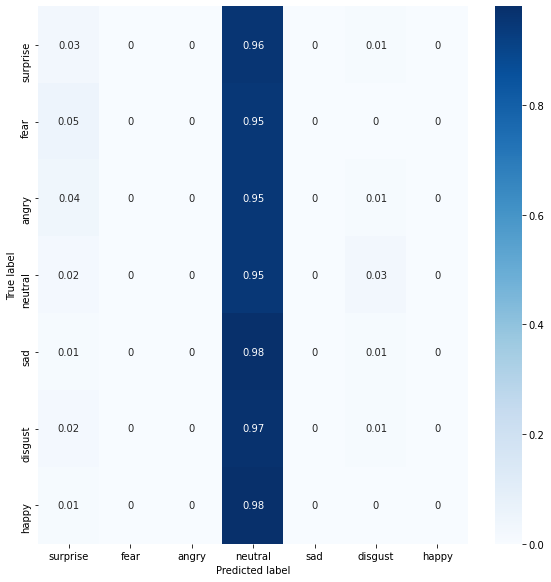

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_trueres, y_predres)
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(labels=y_trueres, predictions=y_predres).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = target_names, 
                                columns = target_names)


import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()